In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from IPython import display
import matplotlib.animation as animation
from datetime import datetime
from torch.optim.optimizer import Optimizer
import hamiltorch
import corner
import scipy

import sys
sys.path.append("..")
from src.datasets import SimpleRegressionDataset
from src.models import OneHiddenLayerFeedForwardNetwork
from src.utils import EarlyStopping
# from models import OneHiddenLayerTanhNetwork, TrainOptimizerSGLD


# CODE YET TO BE ABSTRACTED

In [4]:
class OneHiddenLayerTanhNetwork(nn.Module):
    """
    1-hidden layer tanh network with no bias terms. 
    """
    def __init__(self, input_dim=1, output_dim=1, H=1, init_param=None, activation=None):
        super(OneHiddenLayerTanhNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, H, bias=False)
        self.fc_2 = nn.Linear(H, output_dim, bias=False)
        
        if activation is None:
            self.activation = torch.tanh
        else:
            self.activation = activation

        if init_param is not None:
            self.set_parameters(init_param)

    def forward(self, x):
        x = self.activation(self.fc_1(x))
        x = self.fc_2(x)
        return x
    
    def loglik(self, data, sigma=1.0, inverse_temp=1.0):
        # Evaluates the log of the likelihood given a set of X and Y
        X, y = data[:]
        yhat = self.forward(X)
        logprob = torch.distributions.Normal(y, sigma).log_prob(yhat)
        return logprob.sum() * inverse_temp

    def logprior(self):
        # Return a scalar of 0 since we have uniform prior
        return torch.tensor(0.0)
    
    def logpost_unnormalised(self, data):
        return self.loglik(data) + self.logprior()

    def set_parameters(self, parameters):
        state_dict = self.state_dict()
        for i in [0, 1]:
            name = f"fc_{i + 1}.weight"
            shape = state_dict[name].shape
            state_dict[name] = torch.tensor(parameters[i], requires_grad=True).reshape(shape)
        self.load_state_dict(state_dict)
        return 

    def flatten_parameter(self):
        return torch.vstack([
            self.get_parameter(f"fc_{i + 1}.weight").flatten() for i in [0, 1]
        ]).T.ravel()
    
class LearningMachine(object):
    def __init__(
        self, 
        model, 
        train_dataset, 
        test_dataset,
        loss_fn, 
        optimiser, 
        batch_size=None,
        batch_fraction=None,
        device="cpu", 
    ):
        self.device = device
        # model
        self.model = model
        self.model.to(device)
        
        # dataset
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

        # set batch size
        if batch_size is not None:
            self.batch_size = batch_size
        elif batch_fraction is not None:
            self.batch_size = max(int(len(self.train_dataset) * batch_fraction), 1)
        else:
            self.batch_size = max(len(self.train_dataset) // 5)
            
        # dataloaders
        self.train_dataloader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size, 
            shuffle=True
        )
        self.test_dataloader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size, 
            shuffle=True
        )
        
        # loss function
        self.loss_fn = loss_fn
        
        # training config
        self.optimiser = optimiser
        self.epoch = 0
        self.num_gradient_steps = 0
        self.train_loss = self.compute_loss(self.train_dataset)
        self.history = {}
        self.snapshot()
        
    def training_loop(self, epoch, stopping_condition=None):
        while self.epoch < epoch:
            train_loss = self.train(self.train_dataloader)
            self.epoch += 1
            
            if stopping_condition is not None:
                if stopping_condition(self):
                    break
        return 
    
    def train(self, dataloader):
        self.model.train()
        for batch, (X, y) in enumerate(dataloader):
#             X, y = X.to(self.device), y.to(self.device)
            # Compute prediction error
            pred = self.model(X)
            self.train_loss = self.loss_fn(pred, y)
            
            # Backpropagation
            self.optimiser.zero_grad()
            # TODO: Find out what went wrong here.. retain_graph=True shouldn't be needed.
            self.train_loss.backward(retain_graph=True) 
            self.optimiser.step()
            self.num_gradient_steps += 1
            # Might be a bit too much to snapshot every gradient step... 
            self.snapshot()
        return self.train_loss.item()
    
    def snapshot(self, include_test_loss=False, include_train_loss=True):        
        info_bundle = {
            "parameter": self.model.flatten_parameter(),
            "epoch": self.epoch, 
        }
        if include_test_loss: 
            info_bundle["test_loss"] = self.compute_loss(self.test_dataset)
        if include_train_loss:
            info_bundle["train_loss"] = self.train_loss
#             info_bundle["train_loss"] = self.compute_loss(self.train_dataset)
        self.history[self.num_gradient_steps] = info_bundle
        return info_bundle
        
    def compute_loss(self, dataset):
        X, y = dataset[:]
        pred = self.model(X)
        return self.loss_fn(pred, y).item()
    
    def test(self):
        return self.compute_loss(self.test_dataset)
    
    def eval_loglikelihood(self, new_param_state_dicts):
        model_copy = copy.deepcopy(self.model)
        loglikelihood_lists = []
        for state_dict in new_param_state_dicts:
            model_copy.load_state_dict(state_dict)
            loglikelihood_lists.append(model_copy.loglik(self.train_dataset))
        return np.array(loglikelihood_lists)

ACTIVATION_FUNC = lambda x: torch.clip(x, min=-1, max=1)
OPTIMISER_SWITCH = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD, 
}
def _generate_data(reg_func, n, xlims, sigma):
    X = torch.rand((n, 1)) * (xlims[1] - xlims[0]) + xlims[0]
    y = reg_func(X) + torch.randn_like(X) * sigma
    return X, y


class TrainOptimizerSGLD(Optimizer):
    def __init__(self, net, inverse_temp=1.0, alpha=1e-4):
        super(TrainOptimizerSGLD, self).__init__(net.parameters(), {})
        self.net = net
        self.alpha = alpha
        self.inverse_temp = inverse_temp
        self.original_params = dict(self.net.named_parameters())
        self.losses = []
    
    def step(self, batch, batch_size=1, num_data=1):
        self.zero_grad()
        weight = num_data / batch_size
  
        loss = -self.net.loglik(batch, inverse_temp=self.inverse_temp) * weight - self.net.logprior()
        # Should introduce some sort of restoring force to prevent trajectory wandering far away
        # Force should be zero near the origin, so a bump function of sort... 
#         if restoring_force > 0:
#             sqdist = 0
#             for name, param in self.net.named_parameters():
#                 sqdist += torch.sum((param - self.original_params[name])**2)
#             loss -= restoring_force * sqdist
        loss.backward(retain_graph=True)
        
        with torch.no_grad():
            for name, param in self.net.named_parameters():
                newparam = (
                    param - 0.5 * self.alpha * param.grad 
                    + torch.normal(torch.zeros_like(param), std=self.alpha)
                )
                param.copy_(newparam)
        return loss

    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
        self.parameter_trace = {
            key : torch.zeros( (num_steps,) + par.size()) 
            for key, par in self.net.named_parameters()
        }

        for s in range(num_steps):
            loss = self.step(data)
            
            for key, val in self.net.named_parameters():
                self.parameter_trace[key][s,] = val.data
        return
    
                
    

Text(0.5, 1.0, 'True regression function. n=100')

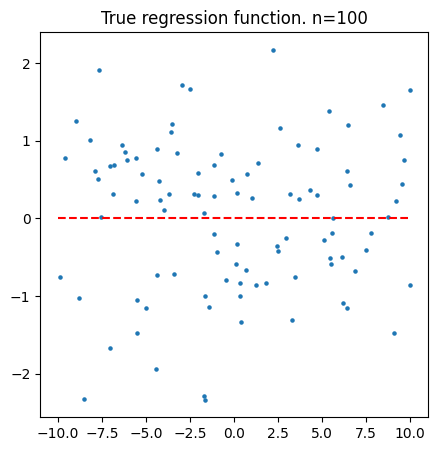

In [5]:
param_true = (0.5, 0.0)
# activation = lambda x: torch.clip(x, min=-1, max=1)
# const_param_true = 0.5
regression_fn_true = OneHiddenLayerTanhNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true, 
#     activation=activation
)

n = 100
n_test = 100

xlims = (-10, 10)
sigma = 1
X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
with torch.no_grad():
    ax.scatter(X_train, y_train, s=5)
#     plt.scatter(X_test, y_test)
    x = torch.linspace(xlims[0], xlims[1], steps=100).reshape(-1, 1)
    ax.plot(x, regression_fn_true(x), "r--")
ax.set_title(f"True regression function. n={n}")

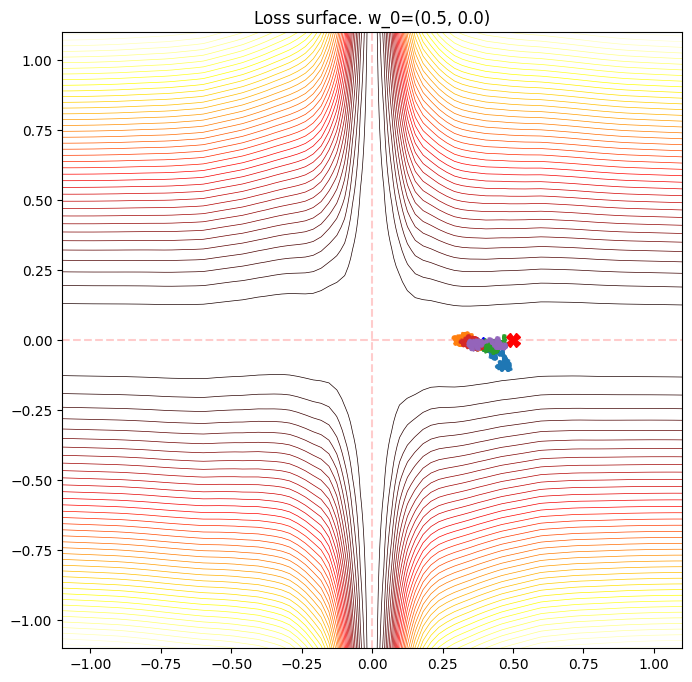

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
low, high = -1.1, 1.1
w1_axis = np.linspace(low, high, num=80)
w2_axis = np.linspace(low, high, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)

with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            reg_func = OneHiddenLayerTanhNetwork(init_param=(W1[i, j], W2[i, j]), activation=ACTIVATION_FUNC)
            Z[i, j] = torch.mean((reg_func(X_train) - y_train)**2)
ax.contour(W1, W2, -np.log(Z), levels=50, alpha=1, linewidths=0.5, cmap="hot_r")
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=low, ymax=high, linestyles="dashed", color="red", alpha=0.2)
ax.hlines([0], xmin=low, xmax=high, linestyles="dashed", color="red", alpha=0.2)
ax.set_title(f"Loss surface. w_0={param_true}");

train_dataset = SimpleRegressionDataset(X_train, y_train)
test_dataset = SimpleRegressionDataset(X_test, y_test)
loss_fn = nn.MSELoss()

rec = {}
for run_num in range(1):
    rec[run_num] = {}
    model = OneHiddenLayerTanhNetwork(H=1)
    machine = LearningMachine(
        model, 
        train_dataset,
        test_dataset, 
        loss_fn, 
        OPTIMISER_SWITCH["sgd"](model.parameters(), lr=0.001), 
    #     batch_size=batch_size,
        batch_fraction=0.2,
    )
    early_stopping = EarlyStopping(patience=5, epsilon=1e-4)
    machine.training_loop(1000, stopping_condition=early_stopping.early_stopping_by_train_loss_improvement)
    param_final = machine.history[max(machine.history.keys())]["parameter"].detach()
    ax.plot([param_final[0]], [param_final[1]], "bX", markersize=10)
    for beta in [0.001, 0.1, 0.4, 0.5, 0.9]:
        inv_temp = beta / np.log(n)
        sgld = TrainOptimizerSGLD(copy.deepcopy(machine.model), alpha=0.001, inverse_temp=inv_temp)
        sgld.fit(train_dataset, num_steps=5000)
        w1, w2 = [sgld.parameter_trace[f"fc_{i}.weight"].flatten() for i in [1, 2]]
        ax.plot(w1, w2, "+--", markersize=2, alpha=0.3)
#         print(f"temp={inv_temp}. Done.")
        rec[run_num][inv_temp] = sgld

# a = 0.3
# ax.set_xlim(xmin=param_final[0] - a, xmax=param_final[0] + a)
# ax.set_ylim(ymin=param_final[1] - a, ymax=param_final[1] + a)

In [9]:

def estimate_local_rlct(sgld1, sgld2, n):
    loss_sum_1 = np.mean(np.array(sgld1.losses)) * n
    loss_sum_2 = np.mean(np.array(sgld2.losses)) * n
    
    numerator = loss_sum_1 - loss_sum_2
    denominator = (1 / sgld1.inverse_temp) - (1 / sgld2.inverse_temp)
    return numerator / denominator

def estimate_local_rlct_single_sample(sgld, n, sigma, thin=1, burn_in=0):
    loss_sum = np.array(sgld.losses) * n * 1/(2 * sigma**2) + 0.5 * np.log(2 * np.pi * sigma**2)
    loss_sum = loss_sum[burn_in::thin]
    
    inv_temp_org = sgld.inverse_temp
    inv_temp_new = inv_temp_org + 0.5 / np.log(n)
    inv_temp_diff = inv_temp_new - inv_temp_org
    weights = np.exp(- inv_temp_diff * loss_sum)

    mean_loss_sum_org = np.mean(loss_sum)
    mean_loss_sum_new = np.mean(weights * loss_sum) / np.mean(weights)
    
    return (mean_loss_sum_org - mean_loss_sum_new) / ((1 / inv_temp_org) - (1 / inv_temp_new))

    

import itertools
run_num = 0
run_rec = rec[run_num]
inv_temps = sorted(run_rec.keys())
# for itemp1, itemp2 in itertools.combinations(inv_temps, 2):
#     rlct_est = estimate_local_rlct(
#         run_rec[itemp1], 
#         run_rec[itemp2], 
#         n
#     )
#     print(rlct_est)

a = [
    estimate_local_rlct_single_sample(run_rec[itemp], n, sigma, thin=2, burn_in=1000)
    for itemp in inv_temps
]
print(a)
print(np.mean(a))

[nan, nan, nan, nan, nan]
nan


/Users/edmund/.local/share/virtualenvs/phase-transition-in-singular-model-paper-ynjlvyrD/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edmund/.local/share/virtualenvs/phase-transition-in-singular-model-paper-ynjlvyrD/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


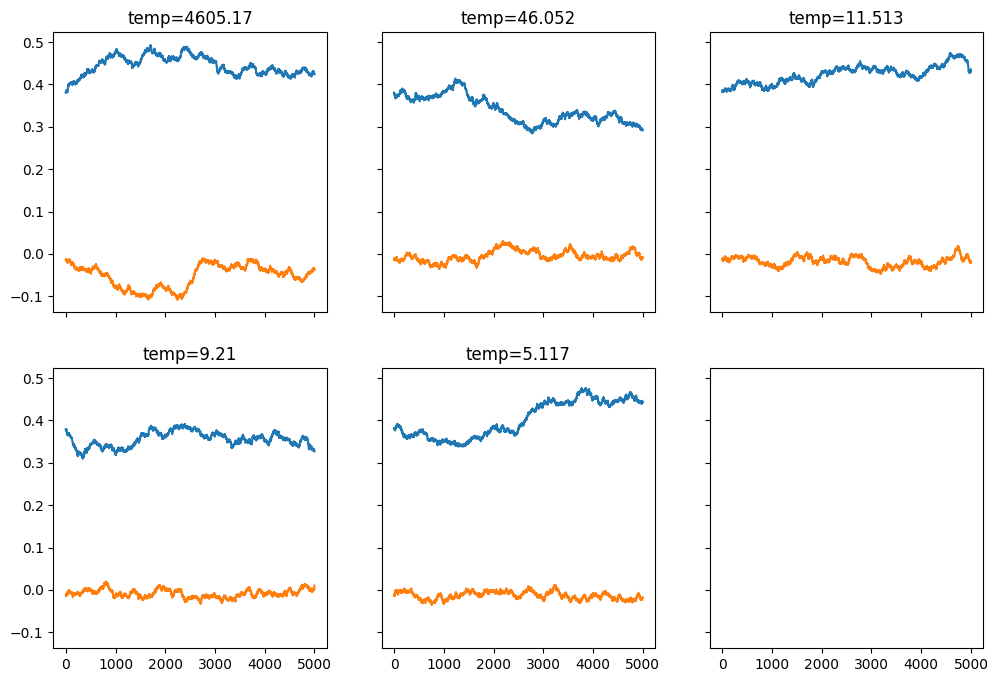

In [10]:
num_cols = 3
num_rows = len(rec[0]) // num_cols + (len(rec[0]) % num_cols != 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)
axes = np.ravel(axes)
run_rec = rec[0]

for ax, itemp in zip(axes, sorted(run_rec.keys())):
    sgld = run_rec[itemp]
    ax.plot(sgld.parameter_trace["fc_1.weight"].flatten())
    ax.plot(sgld.parameter_trace["fc_2.weight"].flatten())
    ax.set_title(f"temp={np.around(1/itemp, 3)}")

# Using `Hamiltorch`

In [437]:
device = "cpu"

param_true = (0.5, 0.0)
regression_fn_true = OneHiddenLayerFeedForwardNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true, 
#     activation=activation
)

n = 1000
n_test = 100
H = 1
xlims = (-10, 10)
sigma = 0.1
X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)


train_dataset = SimpleRegressionDataset(X_train, y_train)
test_dataset = SimpleRegressionDataset(X_test, y_test)
loss_fn = nn.MSELoss()

model = OneHiddenLayerTanhNetwork(
    H=H, 
    init_param=torch.tensor(param_true)
#     init_param=torch.zeros(2 * H)
)
machine = LearningMachine(
    model, 
    train_dataset,
    test_dataset, 
    loss_fn, 
    OPTIMISER_SWITCH["adam"](model.parameters(), lr=0.001), 
#     batch_size=batch_size,
    batch_fraction=0.2,
)
# early_stopping = EarlyStopping(patience=5, epsilon=1e-4)
# print("Training")
# machine.training_loop(1000, stopping_condition=early_stopping.early_stopping_by_train_loss_improvement)
# print("Done")
param_final = hamiltorch.util.flatten(machine.model).to(device).clone().detach()
print(f"final parameter: {param_final}")

def _load_model_params(model, new_params):
#     new_model = copy.deepcopy(model)
    index = 0
    for param in model.parameters():
        param_size = int(torch.prod(torch.tensor(param.size())).item())
        end_index = index + param_size
        new_param_slice = new_params[index: end_index].reshape(param.shape).clone()
#         param = param - param + new_param_slice
        param.copy_(new_param_slice)
        index = end_index
    return model


# def log_likelihood(params):
#     new_model = _load_model_params(model, params)
#     new_model.eval()
#     yhat = new_model(X_train)
#     loss = loss_fn(yhat, y_train)
#     return loss

# def log_prob_func(params):
#     return log_likelihood(params) + log_prior(params)

def make_log_prob_func(model, loss_fn, X_train, y_train, inv_temp=1.0, device="cpu", epsilon=0.1):
    params_shape_list = []
    params_flattened_list = []
    tau_list = []
    tau_out=1.
    normalizing_const = 1.0
    
    center = hamiltorch.util.flatten(model).to(device).clone().detach()
    
    for weights in model.parameters():
        params_shape_list.append(weights.shape)
        params_flattened_list.append(weights.nelement())

    log_likelihood_func = hamiltorch.samplers.define_model_log_prob(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        params_flattened_list, 
        params_shape_list, 
        tau_list, 
        tau_out, 
        normalizing_const=normalizing_const,  
        device=device
    )
    
    def log_prior_func(params):
#         return torch.distributions.MultivariateNormal(center, 0.1 * torch.eye(len(center))).log_prob(params)

        sqdist = torch.sum((params - center)**2)
        dist = torch.sqrt(sqdist)
#         dist = torch.sqrt(torch.sum((params - center)**2))
#         return -sqdist / (2 * 0.001)
#         dist = torch.abs(params - center).max().item()
        if dist < epsilon:
            return 0
        else:
            return -5 # -10 * sqdist #2 * np.log(epsilon)
        
    
    def log_prob_func(param):
        return log_likelihood_func(param) * inv_temp + log_prior_func(param)
    
    return log_likelihood_func, log_prior_func, log_prob_func



params_init = hamiltorch.util.flatten(model).to(device).clone()
step_size = 0.01
num_samples = 5000
num_steps_per_sample = 10
param_recs = {}
for itemp in np.arange(1, 3, 1):
    print(f"itemp = {itemp}")
    log_likelihood_func, log_prior_func, log_prob_func = make_log_prob_func(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        inv_temp=itemp, 
        epsilon=0.1
    )
#     log_likelihood_func = lambda x: -torch.prod(x ** torch.tensor([2.0, 4.0])) * itemp * n
    
    params_init = torch.tensor([0.0, 0.0])
    params_hmc = hamiltorch.sample(
        log_prob_func=log_prob_func, 
        params_init=params_init, 
        num_samples=num_samples,
        burn=0,
        sampler=hamiltorch.Sampler.HMC, 
        integrator=hamiltorch.Integrator.IMPLICIT, 
        metric=hamiltorch.Metric.SOFTABS, 
    #     fixed_point_threshold=1e-3, 
    #     jitter=0.01,
        num_steps_per_sample=num_steps_per_sample,
        step_size=step_size,
        softabs_const=10**6
    )
    param_recs[itemp] = {}
    param_recs[itemp]["params"] = params_hmc

final parameter: tensor([0.5000, 0.0000])
itemp = 1
Sampling (Sampler.HMC; Integrator.IMPLICIT)


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_78494/3998759531.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_dict[name] = torch.tensor(parameters[i], requires_grad=True).reshape(shape)


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:09 | 0d:00:00:00 | #################### | 5000/5000 | 508.35       
Acceptance Rate 0.89
itemp = 2
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:09 | 0d:00:00:00 | #################### | 5000/5000 | 506.22       
Acceptance Rate 1.00


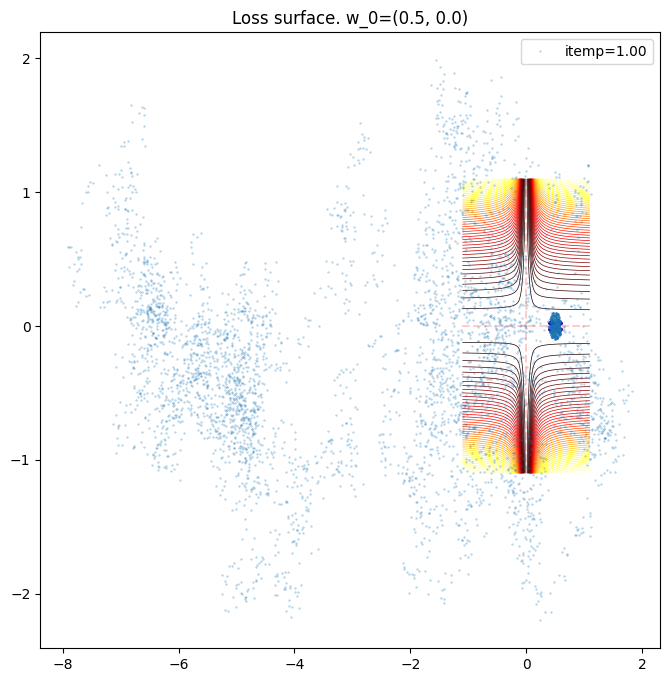

In [438]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
low, high = -1.1, 1.1
xmin, xmax = low, high
ymin, ymax = low, high
# win_size = 0.1
# a = params_init.detach().numpy()
# xmin, xmax = a[0] - win_size, a[0] + win_size
# ymin, ymax = a[1] - win_size, a[1] + win_size
w1_axis = np.linspace(xmin, xmax, num=80)
w2_axis = np.linspace(ymin, ymax, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)

with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            reg_func = OneHiddenLayerTanhNetwork(init_param=(W1[i, j], W2[i, j]), activation=ACTIVATION_FUNC)
            Z[i, j] = torch.mean((reg_func(X_train) - y_train)**2)
ax.contour(W1, W2, -Z, levels=50, alpha=1, linewidths=0.5, cmap="hot_r")
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dashed", color="red", alpha=0.2)
ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dashed", color="red", alpha=0.2)
ax.set_title(f"Loss surface. w_0={param_true}");

ax.plot([param_final[0]], [param_final[1]], "bX", markersize=10)

for itemp, rec in param_recs.items():
#     params_hmc = result["samples"]
    params_hmc = torch.stack(rec["params"])
#     rand_index = np.random.choice(range(params_hmc.shape[0]), size=500)
    rand_index = range(params_hmc.shape[0])
    ax.plot(
        params_hmc[rand_index, 0], 
        params_hmc[rand_index, 1], 
        linewidth=0, 
        marker="+", 
        markersize=1, 
        alpha=0.3, 
        label=f"itemp={itemp:.2f}"
    )
    break
ax.legend()


In [418]:
import ultranest

def ll_func(param):
    return -np.prod(param ** np.array([2.0, 10.0]), axis=-1) #+ np.sum(np.log(param) * np.array([1.0, 1.0]), axis=-1)
    param = torch.from_numpy(param.astype(np.float32))
    with torch.no_grad():
        return log_likelihood_func(param)
    
def transform(param):
    param = param + np.array([0.5, 0.3])
    return (2 * param - 1) * 0.5

ultranest_sampler = ultranest.ReactiveNestedSampler(
    ["w1", "w2"], 
    ll_func, 
#     transform=transform,
#     vectorized=True, 
#     ndraw_min=10, 
)
result = ultranest_sampler.run(
#     show_status=False, 
#     viz_callback=False, 
    log_interval=1000, 
    min_ess=5000,
)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e-34  0.7142..-0.0001] | it/evals=176/589 eff=93.1217% N=400 
[ultranest] Likelihood function evaluations: 710
[ultranest]   logZ = -0.02693 +- 0.003022
[ultranest] Effective samples strategy wants to improve: -0.71..-0.00 (ESS = 651.3, need >5000)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.42, need <0.5)
[ultranest]   logZ error budget: single: 0.04 bs:0.00 tail:0.42 total:0.42 required:<0.50
[ultranest] Widening from 1 to 800 live points before L=-0.7...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 800 live points (have 400 already) ...
[ultranest] Sampling 400 live points from prior ...
[ultranest] Exploring (in particular: L=-inf..-0.00) ...
[ultranest] Explored until L=-4e-34  inf..-0.001] | it/evals=181/1221 eff=89.1892% N=800 
[ultranest] Likelihood function evaluations: 1333
[ultranest]   logZ = -0.

TypeError: FigureBase.colorbar() missing 1 required positional argument: 'mappable'

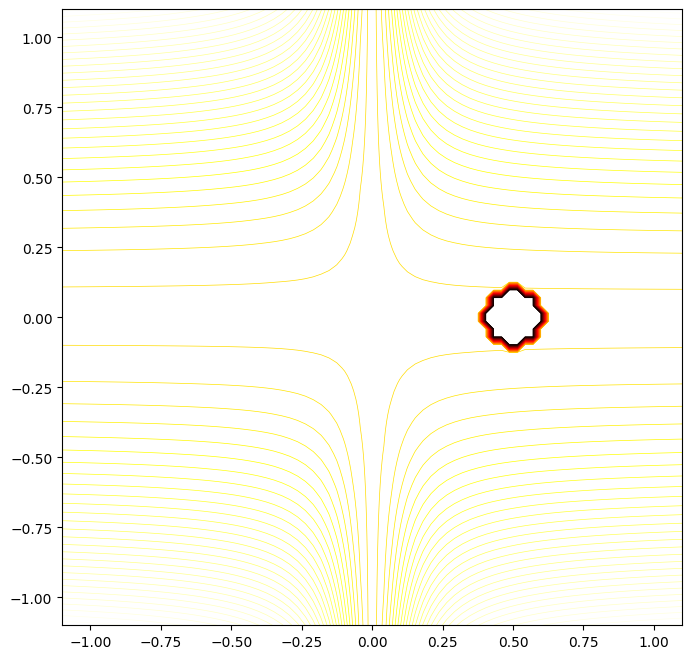

In [443]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

low, high = -1.1, 1.1
w1_axis = np.linspace(low, high, num=80)
w2_axis = np.linspace(low, high, num=80)
# win_size = 0.1
# a = params_init.detach().numpy()
# a = torch.tensor([0.0, 0.0])
# xmin, xmax = a[0] - win_size, a[0] + win_size
# ymin, ymax = a[1] - win_size, a[1] + win_size
# w1_axis = np.linspace(xmin, xmax, num=80)
# w2_axis = np.linspace(ymin, ymax, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)

with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            Z[i, j] = log_prob_func(torch.tensor([W1[i, j], W2[i, j]], dtype=torch.float))
#             Z[i, j] = log_likelihood_func(torch.tensor([W1[i, j], W2[i, j]], dtype=torch.float))
#             Z[i, j] = log_prior_func(torch.tensor([W1[i, j], W2[i, j]], dtype=torch.float))
#             Z[i, j] = ll_func(np.array([W1[i, j], W2[i, j]]))
ax.contour(W1, W2, Z, levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
fig.colorbar()

1.00, 2.00, 

Text(0.5, 1.0, 'slope=-3677.4296875, intercept=47400.806640625')

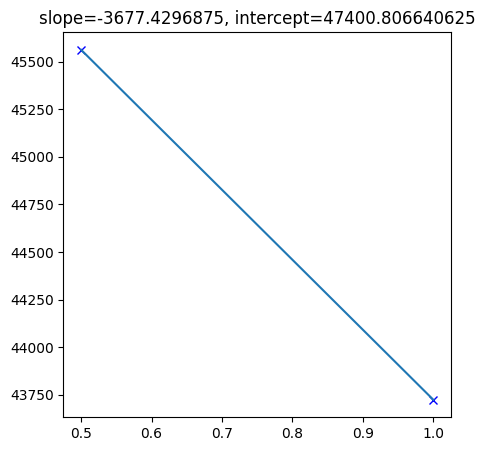

In [440]:
expected_nlns = []
temps = []

for itemp, rec in param_recs.items():
    print(f"{itemp:.2f}", end=", ")
    params_hmc = rec["params"]
    pred_list, log_prob_list = hamiltorch.predict_model(
        model, 
        x=X_train, 
        y=y_train, 
        samples=params_hmc, 
        model_loss=loss_fn,
    )
    rec["pred_list"] = pred_list
    rec["log_prob_list"] = log_prob_list
    
    expected_nlns.append(-torch.stack(log_prob_list).sum())
    temps.append(1 / itemp)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.array(temps), expected_nlns, "bx")
slope, intercept, r_val, _, _ = scipy.stats.linregress(temps, expected_nlns)
ax.plot(temps, np.array(temps) * slope + intercept)
ax.set_title(f"slope={slope}, intercept={intercept}")

In [20]:
def estimate_local_rlct_raw_data(loss_sum_1, loss_sum_2, itemp1, itemp2):
    return (torch.mean(loss_sum_1) - torch.mean(loss_sum_2)) / (1 / itemp1 - 1 / itemp2)

for itemp1, itemp2 in itertools.combinations(param_recs.keys(), 2):
    rlct = estimate_local_rlct_raw_data(
        -torch.stack(param_recs[itemp1]["log_prob_list"]), 
        -torch.stack(param_recs[itemp2]["log_prob_list"]), 
        itemp1,
        itemp2
    )
    print(f"{itemp1:.1f}, {itemp2:.1f}, {rlct:.3f}")

0.1, 0.2, 0.003
0.1, 0.3, 0.003
0.1, 0.4, 0.001
0.1, 0.5, -0.002
0.1, 0.6, 0.000
0.1, 0.7, 0.001
0.1, 0.8, -0.000
0.1, 0.9, 0.001
0.1, 1.0, 0.001
0.2, 0.3, 0.004
0.2, 0.4, -0.001
0.2, 0.5, -0.010
0.2, 0.6, -0.003
0.2, 0.7, -0.002
0.2, 0.8, -0.004
0.2, 0.9, -0.000
0.2, 1.0, -0.001
0.3, 0.4, -0.013
0.3, 0.5, -0.028
0.3, 0.6, -0.010
0.3, 0.7, -0.008
0.3, 0.8, -0.011
0.3, 0.9, -0.004
0.3, 1.0, -0.004
0.4, 0.5, -0.054
0.4, 0.6, -0.008
0.4, 0.7, -0.004
0.4, 0.8, -0.010
0.4, 0.9, 0.002
0.4, 1.0, 0.000
0.5, 0.6, 0.061
0.5, 0.7, 0.039
0.5, 0.8, 0.019
0.5, 0.9, 0.034
0.5, 1.0, 0.028
0.6, 0.7, 0.009
0.6, 0.8, -0.015
0.6, 0.9, 0.017
0.6, 1.0, 0.011
0.7, 0.8, -0.046
0.7, 0.9, 0.023
0.7, 1.0, 0.012
0.8, 0.9, 0.112
0.8, 1.0, 0.054
0.9, 1.0, -0.019


(10000, 6)


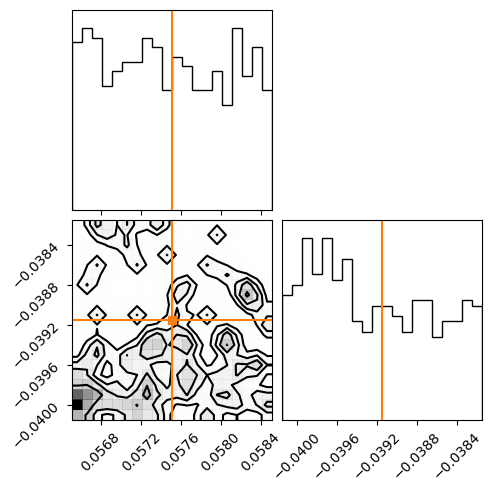

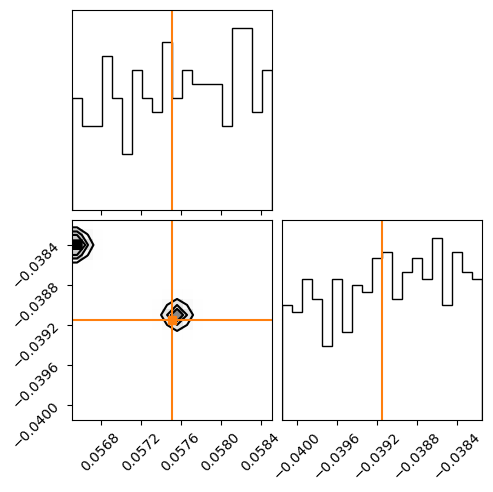

In [736]:
figure = corner.corner(
    data=torch.stack(params_hmc).detach().numpy(), 
    smooth=0.8,
    range=[(val - epsilon, val + epsilon) for val in param_final],
    truths=param_final.detach().numpy(),
    truth_color="C1",
);

# figure = corner.corner(
#     data=torch.stack(params_hmc_2).detach().numpy(), 
#     smooth=0.8,
#     range=[(val - epsilon, val + epsilon) for val in param_final],
#     truths=param_final.detach().numpy(),
#     truth_color="C1",
# );

# value1 = param_final.detach().numpy()
# corner.overplot_lines(figure, value1, color="C1")
# corner.overplot_points(figure, value1[None], marker="s", color="C1")

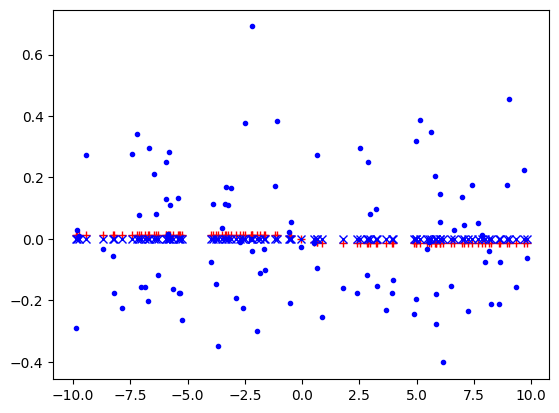

In [529]:
with torch.no_grad():
    plt.plot(X_train, model(X_train), "r+")
    plt.plot(X_train, regression_fn_true(X_train), "bx")
    plt.plot(X_train, y_train, "b.")

# Testing on CIFAR10

In [566]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

Files already downloaded and verified
Files already downloaded and verified


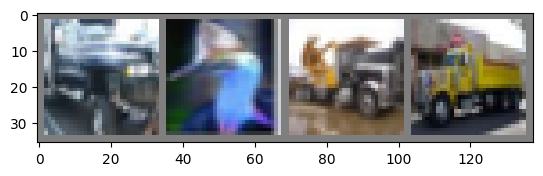

truck bird  truck truck


In [567]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='../Dataset/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../Dataset/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [568]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN()
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [570]:
num_epoch = 10
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


[1,  2000] loss: 2.173
[1,  4000] loss: 1.859
[1,  6000] loss: 1.664
[1,  8000] loss: 1.598
[1, 10000] loss: 1.545
[1, 12000] loss: 1.496
[2,  2000] loss: 1.416
[2,  4000] loss: 1.398
[2,  6000] loss: 1.336
[2,  8000] loss: 1.327
[2, 10000] loss: 1.295
[2, 12000] loss: 1.271
[3,  2000] loss: 1.214
[3,  4000] loss: 1.192
[3,  6000] loss: 1.184
[3,  8000] loss: 1.180
[3, 10000] loss: 1.174
[3, 12000] loss: 1.172
[4,  2000] loss: 1.089
[4,  4000] loss: 1.092
[4,  6000] loss: 1.085
[4,  8000] loss: 1.070
[4, 10000] loss: 1.118
[4, 12000] loss: 1.073
[5,  2000] loss: 0.999
[5,  4000] loss: 0.980
[5,  6000] loss: 1.013
[5,  8000] loss: 1.015
[5, 10000] loss: 1.035
[5, 12000] loss: 1.038
[6,  2000] loss: 0.909
[6,  4000] loss: 0.966
[6,  6000] loss: 0.952
[6,  8000] loss: 0.967
[6, 10000] loss: 0.994
[6, 12000] loss: 0.961
[7,  2000] loss: 0.877
[7,  4000] loss: 0.900
[7,  6000] loss: 0.916
[7,  8000] loss: 0.919
[7, 10000] loss: 0.928
[7, 12000] loss: 0.938
[8,  2000] loss: 0.820
[8,  4000] 

In [606]:
X_train, y_train = trainset[0]
X_train = X_train[None]
y_train = [y_train]
for i in range(1, 1000): #len(trainset)):
    a, b = trainset[i]
    X_train = torch.concat([X_train, a[None]], dim=0)
    y_train.append(b)
y_train = torch.tensor(y_train)

In [636]:
def log_prior(params):
    epsilon = 1e-2
#     dist = torch.sqrt(torch.sum(params - param_final)**2)
    dist = torch.abs(params - params_init).max().item()
    if dist < epsilon:
        return 0
    else:
        return -100000
#         return -torch.inf

def make_log_prob_func(model, loss_fn, X_train, y_train, inv_temp=1.0, device="cpu"):
    params_shape_list = []
    params_flattened_list = []
    tau_list = []
    tau_out=1.
    normalizing_const = 1.0
    
    for weights in model.parameters():
        params_shape_list.append(weights.shape)
        params_flattened_list.append(weights.nelement())

    log_likelihood_func = hamiltorch.samplers.define_model_log_prob(
        model, 
        loss_fn, 
        X_train, 
        y_train, 
        params_flattened_list, 
        params_shape_list, tau_list, tau_out, normalizing_const=normalizing_const,  device = device)
    
    def log_prob_func(param):
        return log_likelihood_func(param) * inv_temp + log_prior(param)
    return log_prob_func

net = copy.deepcopy(model)
device = "cpu"
params_init = hamiltorch.util.flatten(net).to(device).clone()
# params_init = torch.zeros(2)
step_size = 0.0005
num_samples = 1000
num_steps_per_sample = 1

log_prob_func = make_log_prob_func(model, loss_fn, X_train, y_train, inv_temp=0.5)
params_hmc = hamiltorch.sample(
    log_prob_func=log_prob_func, 
    params_init=params_init, 
    num_samples=num_samples,
    burn=0,
    sampler=hamiltorch.Sampler.HMC, 
    integrator=hamiltorch.Integrator.IMPLICIT, 
    metric=hamiltorch.Metric.SOFTABS, 
#     fixed_point_threshold=1e-3, 
#     jitter=0.01,
    num_steps_per_sample=num_steps_per_sample,
    step_size=step_size,
    softabs_const=10**6
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:06:39 | 0d:00:00:00 | #################### | 1000/1000 | 2.51       
Acceptance Rate 0.03


In [690]:
log_prob_func = make_log_prob_func(model, loss_fn, X_train, y_train, inv_temp=1)
params_hmc2 = hamiltorch.sample(
    log_prob_func=log_prob_func, 
    params_init=params_init, 
    num_samples=num_samples,
    burn=0,
    sampler=hamiltorch.Sampler.HMC, 
    integrator=hamiltorch.Integrator.IMPLICIT, 
    metric=hamiltorch.Metric.SOFTABS, 
#     fixed_point_threshold=1e-3, 
#     jitter=0.01,
    num_steps_per_sample=num_steps_per_sample,
    step_size=step_size,
    softabs_const=10**6
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec


KeyboardInterrupt: 

In [638]:
pred_list, log_prob_list = hamiltorch.predict_model(
    model, 
    x=X_train, 
    y=y_train, 
    samples=params_hmc, 
    model_loss=loss_fn, 
)

In [689]:
np.mean(log_prob_list)

-57370.89

In [700]:
log_prob_list

[tensor(-57370.6836),
 tensor(-57370.6758),
 tensor(-57370.6914),
 tensor(-57370.7031),
 tensor(-57370.7227),
 tensor(-57370.7266),
 tensor(-57370.7461),
 tensor(-57370.7617),
 tensor(-57370.7578),
 tensor(-57370.7539),
 tensor(-57370.7812),
 tensor(-57370.7969),
 tensor(-57370.8086),
 tensor(-57370.8086),
 tensor(-57370.8047),
 tensor(-57370.8086),
 tensor(-57370.8164),
 tensor(-57370.8242),
 tensor(-57370.8398),
 tensor(-57370.8438),
 tensor(-57370.8555),
 tensor(-57370.8555),
 tensor(-57370.8555),
 tensor(-57370.8555),
 tensor(-57370.8750),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-57370.8477),
 tensor(-5

In [673]:
_, preds = torch.max(pred_list, 2)
preds

tensor([[6, 9, 9,  ..., 1, 7, 5],
        [6, 9, 9,  ..., 1, 7, 5],
        [6, 9, 9,  ..., 1, 7, 5],
        ...,
        [6, 9, 9,  ..., 1, 7, 5],
        [6, 9, 9,  ..., 1, 7, 5],
        [6, 9, 9,  ..., 1, 7, 5]])

In [685]:
_, preds = torch.max(torch.mean(pred_list, 0), 1)

In [686]:
(preds == y_train).sum() / y_train.shape[0]

tensor(0.7160)

In [675]:
(torch.mode(preds, dim=0)[0] == y_train).sum() / y_train.shape[0]

tensor(0.)

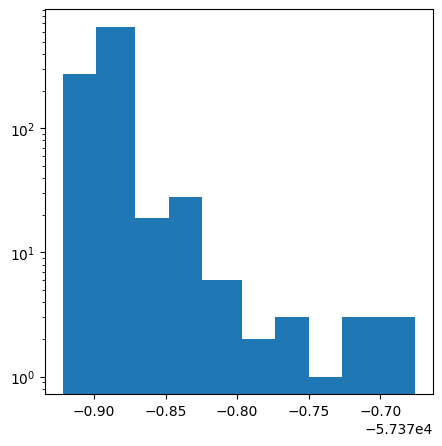

In [706]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
a = torch.stack(log_prob_list)
ax.hist(a);
ax.set_yscale('log')
